# Straggler experiments (figure 9)

Use bagging to train an ensemble of models for Clipper to demonstrate the effects of stragglers

In [10]:
import pandas as pd
import numpy as np
import sklearn.linear_model
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')


def load_digits(digits_location, digits_filename = "train-mnist-dense-with-labels.data"):
    digits_path = os.path.join(digits_location, digits_filename)
    print "Source file:", digits_path
    df = pd.read_csv(digits_path, sep=",", header=None)
    data = df.values
    print "Number of image files:", len(data)
    y = data[:,0]
    X = data[:,1:]
    return (X, y)

def to_image(x):
    return np.reshape(x,[28,28])

def display_digit(x):
    plt.imshow(to_image(x), interpolation='none')

def display_random_digits(X, y):
    ind = np.random.permutation(len(X))
    plt.figure()
    for i in range(0, 16):
        plt.subplot(4,4,i+1)
        display_digit(X[ind[i],:])
        plt.draw()
        # Display the plot

        
def normalize_digits(X):
    mu = np.mean(X,0)
    sigma = np.var(X,0)
    Z = (X - mu) / np.array([np.sqrt(z) if z > 0 else 1. for z in sigma])
    return Z 

def fourier_project(X, nfeatures = 4096, scale = 1.e-4):
    (n,d) = X.shape
    W = np.random.normal(scale = scale, size = [d, nfeatures])
    phase = np.random.uniform( size = [1, nfeatures]) * 2.0 * np.pi
    randomFeatures = np.cos(X.dot(W) + phase)
    return randomFeatures

def filter_two_class(X, y, digitA = 3, digitB = 9):
    indexes = (y == (digitA + 1)) | (y == (digitB + 1))
    binary_labels = (y == (digitA + 1)) * 1.
    return (X[indexes], binary_labels[indexes])
    
#     return (yInd, yBinary[yInd])


def train_test_split(y, propTrain = 0.75):
    ind = np.random.permutation(len(y))
    split_ind = ind[0.75 * len(y)]
    train_ind = ind[:split_ind]
    test_ind = ind[split_ind:]
    print "Train size: ", len(train_ind)
    print "Train true: ", np.mean(y[train_ind] == 1.0)
    print "Test size:  ", len(test_ind)
    print "Test true:  ", np.mean(y[test_ind] == 1.0)
    return (train_ind, test_ind)


In [2]:
# # Load data
train_x, train_y = load_digits(os.path.expanduser("/Users/crankshaw/model-serving/data/mnist_data"))
train_x = normalize_digits(train_x)

test_x, test_y = load_digits(os.path.expanduser("/Users/crankshaw/model-serving/data/mnist_data"), "test-mnist-dense-with-labels.data")
test_x = normalize_digits(test_x)



Source file: /Users/crankshaw/model-serving/data/mnist_data/train-mnist-dense-with-labels.data
Number of image files: 60000
Source file: /Users/crankshaw/model-serving/data/mnist_data/test-mnist-dense-with-labels.data
Number of image files: 10000


In [12]:
# Train decision tree classifiers
models = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=20, max_samples=0.1, n_jobs=-1)
models.fit(train_x, train_y)

# Look at baseline score
print "Ensemble score: %f" % models.score(test_x, test_y)
for m in models.estimators_:
    print m.score(test_x, test_y - 1)

# Run straggler experiment

def vote(estimators, x, y):
    votes = np.zeros(len(estimators[0].classes_))
    for m in estimators:
        y_pred = m.predict(x)
        votes[y_pred] += 1
    y_hat = np.argmax(votes) + 1
    return int(y_hat == y)
    
scores = []    
for num_estimators in range(1,21):
    num_correct = 0
    for i in range(len(test_y)):
        num_correct += vote(models.estimators_[:num_estimators], test_x[i].reshape(1,-1), test_y[i])
    score = float(num_correct)/float(len(test_y))
    print score
    scores.append(score)
scores.reverse()

Ensemble score: 0.908300
0.5055
0.5438
0.5945
0.7088
0.7342
0.7554
0.638
0.7428
0.7005
0.5185
0.7894
0.7132
0.7452
0.7037
0.5538
0.5173
0.7259
0.5632
0.754
0.771
0.5055
0.542
0.5955
0.6511
0.748
0.818
0.8454
0.8583
0.8704
0.8658
0.8835
0.8918
0.9006
0.9006
0.9005
0.8981
0.9001
0.9004
0.903
0.9083


[0.9083, 0.903, 0.9004, 0.9001, 0.8981, 0.9005, 0.9006, 0.9006, 0.8918, 0.8835, 0.8658, 0.8704, 0.8583, 0.8454, 0.818, 0.748, 0.6511, 0.5955, 0.542, 0.5055]


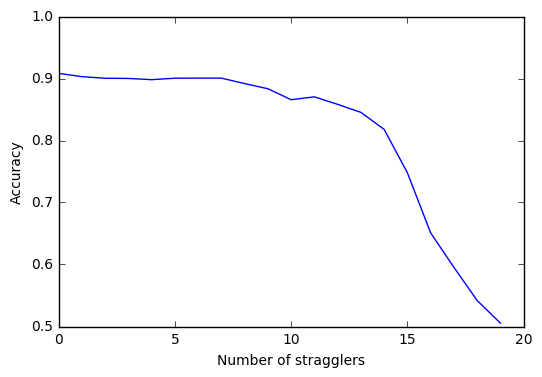

In [13]:
print scores
fig, ax = plt.subplots()
ax.plot(range(20), scores)
ax.set_xlabel("Number of stragglers")
ax.set_ylabel("Accuracy")
ax.set_ylim((ax.get_ylim()[0],1.0))
plt.show()


In [8]:
from sklearn.externals import joblib
base_path = "/Users/crankshaw/clipper-rust/model_wrappers/python/sklearn_models"
for (i,m) in enumerate(models.estimators_):
    dname = os.path.join(base_path, "sklearn_linsvm_10class_%d" % (i+1))
    os.mkdir(dname)
    fname = os.path.join(dname, "sklearn_linsvm_10class_%d.pkl" % (i+1))
    joblib.dump(m, fname)

In [ ]:
preds = models.estimators_[0].predict(test_x[:100])

In [7]:
print scores

[0.9217, 0.9207, 0.9206, 0.9207, 0.9189, 0.9171, 0.9166, 0.9125, 0.9106, 0.9063, 0.9026, 0.9001, 0.8951, 0.8875, 0.8785, 0.8711, 0.8562, 0.8216, 0.7582, 0.7891]
